In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt

In [2]:
"""
#connect with drive
from google.colab import drive
drive.mount('/content/drive')
"""

"\n#connect with drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
"""
# Path to data:
# David's path
path = '/content/drive/MyDrive/Dengue_GIS_Visualization/DengueData/'
# Dana's path
#path='/content/drive/MyDrive/Dengue_GIS Visualization/Dengue_GIS_Visualization/DengueData/'
"""

"\n# Path to data:\n# David's path\npath = '/content/drive/MyDrive/Dengue_GIS_Visualization/DengueData/'\n# Dana's path\n#path='/content/drive/MyDrive/Dengue_GIS Visualization/Dengue_GIS_Visualization/DengueData/'\n"

In [4]:
# Read Data
merge_cases_temp_precip = pd.read_csv('Data/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv')
# Remove extra column
merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)
merge_cases_temp_precip.LastDayWeek = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
merge_cases_temp_precip

/var/folders/4w/k6c16td51cv9ytcmnnvx3mpw0000gn/T/ipykernel_27543/324749813.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)


,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH,temperature_medellin,percipitation_medellin,percipitation_medellin_rural,percipitation_medellin_urbano
0,1,"['2007', 'w01']",2007,200701,2007-01-06,1,21.009283,13.096688,14.097693,12.628933
1,0,"['2007', 'w02']",2007,200702,2007-01-13,1,21.009283,8.437044,6.910390,9.067214
2,0,"['2007', 'w03']",2007,200703,2007-01-20,1,21.009283,19.373165,21.616968,18.406665
3,0,"['2007', 'w04']",2007,200704,2007-01-27,1,21.009283,0.000000,0.000000,0.000000
4,0,"['2007', 'w05']",2007,200705,2007-02-03,2,20.982925,3.725206,3.144225,3.901021
...,...,...,...,...,...,...,...,...,...,...
619,28,"['2018', 'w48']",2018,201848,2018-12-01,12,20.936353,8.916642,8.656351,9.114419
620,12,"['2018', 'w49']",2018,201849,2018-12-08,12,20.936353,17.006086,16.076869,17.334870
621,27,"['2018', 'w50']",2018,201850,2018-12-15,12,20.936353,5.673248,5.388778,5.794555
622,17,"['2018', 'w51']",2018,201851,2018-12-22,12,20.936353,2.785103,2.708024,2.810241


# Time Series

## Data visualization

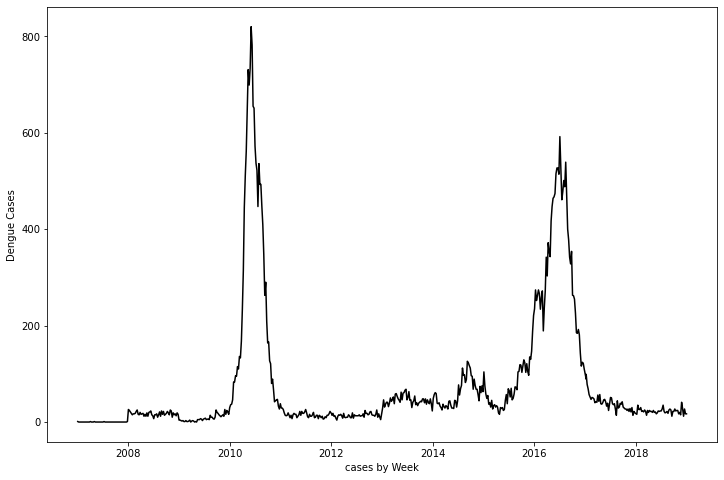

In [5]:
# Dengue cases in time
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (12, 8))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label) 
    plt.ylabel('Dengue Cases')

timeseries(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['cases_medellin'], 'cases by Week')

## DataSet

In [6]:
dataset = merge_cases_temp_precip[['temperature_medellin','percipitation_medellin','cases_medellin']]
dataset.index = merge_cases_temp_precip.LastDayWeek
dataset  #DF

,temperature_medellin,percipitation_medellin,cases_medellin
LastDayWeek,,,
2007-01-06,21.009283,13.096688,1
2007-01-13,21.009283,8.437044,0
2007-01-20,21.009283,19.373165,0
2007-01-27,21.009283,0.000000,0
2007-02-03,20.982925,3.725206,0
...,...,...,...
2018-12-01,20.936353,8.916642,28
2018-12-08,20.936353,17.006086,12
2018-12-15,20.936353,5.673248,27


# Prepare data to supervised learning time series

we will use:
* data: is the dataframe in our case (Dengue Cases, Precipitation and Temperature)
* n_in: is the number of lag weeks in the past (length of window)

The heart of this "series_to_supervised" function is the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a> fuction of pandas

This function gets as input the number of periods(in this case the number of weeks represented as rows up or down in the dataframe) to move the columns of a dataframe.
E.g. 
* If we have merge_cases_temp_precip['cases_medellin'].shift(1) all the rows of column cases_medellin will move one row down
* If we have merge_cases_temp_precip['cases_medellin'].shift(-1) all the rows of column cases_medellin will move one row up


In [7]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

### normalize features
As we are working with a Neural Network the data values ​​must be normalized to help backpropagation algorithm
So we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> from sklearn

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaler between 0 and 1
scaled = scaler.fit_transform(dataset) # As we can see data set has 3 Columns (This shape is also important for inverse scaler as we will see in future)

In [9]:
# length of window
weeks = 10

# frame as supervised learning
data = series_to_supervised(scaled, n_in=weeks)
DataFrame(data).head()

,var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
10,0.364241,0.103033,0.00122,0.364241,0.066375,0.0,0.364241,0.152411,0.0,0.364241,...,0.0,0.493659,0.251632,0.0,0.493659,0.194133,0.00000,0.493659,0.339599,0.00000
11,0.364241,0.066375,0.00000,0.364241,0.152411,0.0,0.364241,0.000000,0.0,0.356053,...,0.0,0.493659,0.194133,0.0,0.493659,0.339599,0.00000,0.493659,0.287922,0.00000
12,0.364241,0.152411,0.00000,0.364241,0.000000,0.0,0.356053,0.029307,0.0,0.356053,...,0.0,0.493659,0.339599,0.0,0.493659,0.287922,0.00000,0.493659,0.718713,0.00000
13,0.364241,0.000000,0.00000,0.356053,0.029307,0.0,0.356053,0.095100,0.0,0.356053,...,0.0,0.493659,0.287922,0.0,0.493659,0.718713,0.00000,0.434987,0.456353,0.00122
14,0.356053,0.029307,0.00000,0.356053,0.095100,0.0,0.356053,0.011560,0.0,0.356053,...,0.0,0.493659,0.718713,0.0,0.434987,0.456353,0.00122,0.434987,0.371302,0.00000


## Features Set

In [10]:
# We define the number of features as 3 (Temperature, Precipitation and Dengue Cases)
n_features = 3
# The features to train the model will be all except the values of the actual week 
# We can't use the temperature and precipitation in week t because whe need to resample a a 3D Array
features_set = DataFrame(data.values[:,:-n_features])
# Convert pandas data frame to np.array to reshape as 3D Array
features_set = features_set.to_numpy()
features_set

array([[0.36424094, 0.10303316, 0.00121951, ..., 0.49365894, 0.19413316,
        0.        ],
       [0.36424094, 0.0663752 , 0.        , ..., 0.49365894, 0.33959896,
        0.        ],
       [0.36424094, 0.15241093, 0.        , ..., 0.49365894, 0.28792167,
        0.        ],
       ...,
       [0.28320738, 0.60463713, 0.03292683, ..., 0.34158643, 0.13378884,
        0.01463415],
       [0.28320738, 0.20007748, 0.02804878, ..., 0.34158643, 0.0446321 ,
        0.03292683],
       [0.28320738, 0.3982439 , 0.02926829, ..., 0.34158643, 0.02191073,
        0.02073171]])

## Labels Set

In [11]:
# We will use Dengue cases in last week 
labels_set = DataFrame(data.values[:,-1])
# Convert pandas data frame to np.array
labels_set = labels_set.to_numpy()
labels_set

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.03170732],
       [0.02926829],
       [0.02560976],
       [0.02195122],
       [0.01829268],
       [0.020

## Train Test Split

In [12]:
# We need a sequence so we can't split randomly
# To divide into Train (90%) and test (10%) to do that we need to know the 90% of the total dataframe
size = features_set.shape[0]
split = int(size*(9/10))

### train

In [13]:
# We will train with 1st 90% of data and test with last 10%
train_X = features_set[:split] ##90% train
train_y = labels_set[:split]  ##90% train

### test

In [14]:
test_X = features_set[split:] ##10% test
test_y = labels_set[split:] ##10% test

## Reshape

In [15]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(552, 10, 3) (552, 1) (62, 10, 3) (62, 1)


### Transform ndarray to tensor pytorch

In [16]:
import torch
train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)
test_X = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_y)

## Model

### LSTM

In [17]:
""" TODO: Pytorch Model implementation"""
import torch.nn as nn
from torch.autograd import Variable

import random
random.seed(0)

torch.manual_seed(0)


# num_classes: weeks to predict (1)
# num_layers: # of activations from past LSTM layers
# input_size: num of features (n_features = 3)
# hidden_size: # Neurons in hidden layer (50)
# seq_length: length of window (weeks)

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Define LSTM layer with hidden_size neurons, input_size inputs and 1 ho and c0
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # Define ouput linear layer takes hidden_size inputs, and num_classes outputs
        self.fc = nn.Linear(hidden_size, num_classes)
        

    def forward(self, x):
        
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # print(f'last activation: {h_out}')
        # print(f'output: {ula[:,-1,:]}') # Last Activation is output in last position
        #print(h_out.shape)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [18]:
# Create instance of nn
num_epochs = 2000
learning_rate = 0.01

input_size = n_features # Features
hidden_size = 60 # LSTM layer neurons
num_layers = 1 # Number of LSTM layers
num_classes = 1 # Output Neurons

# Instance
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = lstm.float()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


# fit network
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(train_X.float())
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, train_y.float())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05393
Epoch: 100, loss: 0.00056
Epoch: 200, loss: 0.00048
Epoch: 300, loss: 0.00044
Epoch: 400, loss: 0.00113
Epoch: 500, loss: 0.00035
Epoch: 600, loss: 0.00053
Epoch: 700, loss: 0.00033
Epoch: 800, loss: 0.00036
Epoch: 900, loss: 0.00027
Epoch: 1000, loss: 0.00031
Epoch: 1100, loss: 0.00019
Epoch: 1200, loss: 0.00017
Epoch: 1300, loss: 0.00015
Epoch: 1400, loss: 0.00013
Epoch: 1500, loss: 0.00013
Epoch: 1600, loss: 0.00011
Epoch: 1700, loss: 0.00010
Epoch: 1800, loss: 0.00011
Epoch: 1900, loss: 0.00009


# Test

In [19]:
from math import sqrt
from numpy import concatenate

# make a prediction
lstm.eval()
train_predict = lstm(test_X.float())
yhat = train_predict.detach().numpy()

In [20]:
yhat.shape

(62, 1)

In [21]:
# Convert test data to 2D 
test_X = test_X.reshape((test_X.shape[0], weeks*n_features))

# invert scaling for forecast
# As we said Scaler needs 3 columns so we can take those columns from test data and take again the predictions
# Concatenate last 2 columns of test data with predicted data (yhat)
inv_yhat = concatenate((test_X[:, -(n_features-1):], yhat), axis=1)
# Inverse Scaler
inv_yhat = scaler.inverse_transform(inv_yhat)
# Take predicted data scaled to original Dengue cases
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
# Same process than for predicted data (yhat)
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -(n_features-1):], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [22]:
from sklearn.metrics import  mean_absolute_error

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 4.897


#### Plot predicted vs actual dengue cases

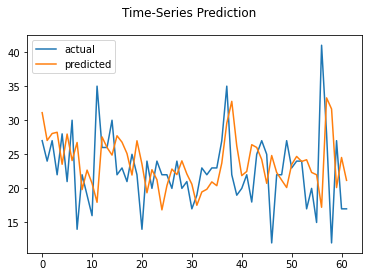

In [23]:
data_predict = inv_yhat  ## predicted target  cases
dataY_plot = inv_y  ##  real test-target cases

data_predict = data_predict.reshape(len(data_predict), 1)
dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

import matplotlib.pyplot as plt

plt.plot(dataY_plot, label = 'actual')
plt.plot(data_predict, label = 'predicted')
plt.legend(loc="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

<ol>
  <li> <a href="https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915">Predictive Analytics: Time-Series Forecasting with GRU and BiLSTM in TensorFlow</a></li>
  <li><a href="https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/">Multivariate Time Series Forecasting with LSTMs in Keras</a></li>
</ol>

tensor([[ 0.7700, -0.3254,  1.7170,  1.5188],
        [ 0.4441, -0.3583,  0.4963, -0.1700],
        [ 0.9152,  0.6018,  1.3149,  0.3651],
        [-0.5918,  0.5252, -0.8966, -1.6934]])


tensor([2, 2, 2, 1])